### Packages

In [1]:
# Import some useful packages for this homework
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset # "ConcatDataset" and "Subset" are possibly useful
from torchvision.datasets import DatasetFolder, VisionDataset
from torchsummary import summary
from tqdm.auto import tqdm
import random
import matplotlib.pyplot as plt
import torch.nn.utils.prune as prune


### Dataset
Use Food11 dataset for this homework.

In [2]:
# fetch and download the dataset from github (about 1.12G)
import gdown
!wget -O Food-11.tar.gz https://www.dropbox.com/s/v97fi9xrwp9b964/food11-hw13.tar.gz?dl=0
# gdown.download('https://drive.google.com/uc?id=1fTMLOeQ0-131Cq6ZLUndiwlTwE2CinYP', 'Food-11.tar.gz')

--2023-07-08 09:23:38--  https://www.dropbox.com/s/v97fi9xrwp9b964/food11-hw13.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/v97fi9xrwp9b964/food11-hw13.tar.gz [following]
--2023-07-08 09:23:38--  https://www.dropbox.com/s/raw/v97fi9xrwp9b964/food11-hw13.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1c8c4f4abdbb2a02fdd8575226.dl.dropboxusercontent.com/cd/0/inline/B_fTa92kEy3sn9LEX4dRuMDzxXZQ4mlUfyWvOQO_fzLKT8TMj--fHpQR_0Onta-Cjn-8kkeSBg_fl-IzFL8RQNL3LtXr5IzAz_ECKQal9Wamt9KD4aJ-BuqVeE8y3oIkyRAC9HxUFxVH8HSOk9j9H90fHnwNtH6a5FXR1PcB86A-EQ/file# [following]
--2023-07-08 09:23:38--  https://uc1c8c4f4abdbb2a02fdd8575226.dl.dropboxusercontent.com/cd/0/inline/B_fTa92kEy3sn9LEX4dRuMDzxXZQ4mlUfyWvOQO_fzLKT8TMj--fHpQR_

In [3]:
# extract the data
!tar -xzf ./Food-11.tar.gz # Could take some time
# !tar -xzvf ./Food-11.tar.gz # use this command if you want to checkout the whole process.

In [4]:
for dirname, _, filenames in os.walk('./Food-11'):
    if len(filenames) > 0:
        print(f"{dirname}: {len(filenames)} files.") # Show the file amounts in each split.

./Food-11: 1 files.
./Food-11/validation: 4432 files.
./Food-11/training: 9993 files.
./Food-11/evaluation: 2218 files.


Data augmentation for tset dataset

In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# define training/testing transforms
test_tfm = transforms.Compose([
    # It is not encouraged to modify this part if you are using the provided teacher model. This transform is stardard and good enough for testing.
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

In [6]:
class FoodDataset(Dataset):
    def __init__(self, path, tfm=test_tfm, files = None):
        super().__init__()
        self.path = path
        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
        if files != None:
            self.files = files
        print(f"One {path} sample",self.files[0])
        self.transform = tfm

    def __len__(self):
        return len(self.files)

    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        try:
            label = int(fname.split("/")[-1].split("_")[0])
        except:
            label = -1 # test has no label
        return im,label

In [7]:
cfg = {
    'dataset_root': './Food-11',
    'batch_size': 64,
}

In [8]:
valid_set = FoodDataset(os.path.join(cfg['dataset_root'], "validation"), tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=cfg['batch_size'], shuffle=False, num_workers=0, pin_memory=True)

One ./Food-11/validation sample ./Food-11/validation/0_0.jpg


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
def evaluate(model):
    model.to(device)
    model.eval()

    valid_accs = []
    valid_lens = []

    for batch in tqdm(valid_loader):
        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().sum()

        # Record the loss and accuracy.
        batch_len = len(imgs)
        valid_accs.append(acc)
        valid_lens.append(batch_len)

    # The average accuracy for entire validation set is the average of the recorded values.
    valid_acc = sum(valid_accs) / sum(valid_lens)
    return valid_acc.item()

### Pruning

In [11]:
valid_acc_list = []

for ratio in np.arange(0, 1, 0.05):
    # Specify the pruning ratio
    ratio = round(ratio, 2)
    # Load model
    teacher_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False, num_classes=11)
    teacher_ckpt_path = os.path.join('./Food-11', "resnet18_teacher.ckpt")
    teacher_model.load_state_dict(torch.load(teacher_ckpt_path, map_location='cpu'))
    for name, module in teacher_model.named_modules():
        if isinstance(module, torch.nn.Conv2d): # if the nn.module is torch.nn.Conv2d
            prune.l1_unstructured(module, name='weight', amount=ratio) # use 'prune' method provided by 'torch.nn.utils.prune' to prune the weight parameters in the nn.Conv2d layers
    # Next, you just have to generize the above code to different ratio and test the accuracy on the validation set of food11-hw13.
    valid_acc = evaluate(teacher_model)
    valid_acc_list.append(valid_acc)
    print(valid_acc)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


  0%|          | 0/70 [00:00<?, ?it/s]

0.9505866169929504


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/70 [00:00<?, ?it/s]

0.9512635469436646


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/70 [00:00<?, ?it/s]

0.9481046795845032


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/70 [00:00<?, ?it/s]

0.949232816696167


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/70 [00:00<?, ?it/s]

0.9442689418792725


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/70 [00:00<?, ?it/s]

0.9440433382987976


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/70 [00:00<?, ?it/s]

0.9280234575271606


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/70 [00:00<?, ?it/s]

0.9074909687042236


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/70 [00:00<?, ?it/s]

0.8862816095352173


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/70 [00:00<?, ?it/s]

0.7842960357666016


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/70 [00:00<?, ?it/s]

0.582129955291748


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/70 [00:00<?, ?it/s]

0.32829421758651733


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/70 [00:00<?, ?it/s]

0.15974728763103485


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/70 [00:00<?, ?it/s]

0.1098826676607132


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/70 [00:00<?, ?it/s]

0.11732851713895798


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/70 [00:00<?, ?it/s]

0.10379061102867126


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/70 [00:00<?, ?it/s]

0.10717508941888809


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/70 [00:00<?, ?it/s]

0.10356497764587402


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/70 [00:00<?, ?it/s]

0.0931859165430069


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/70 [00:00<?, ?it/s]

0.0904783383011818


### Plot

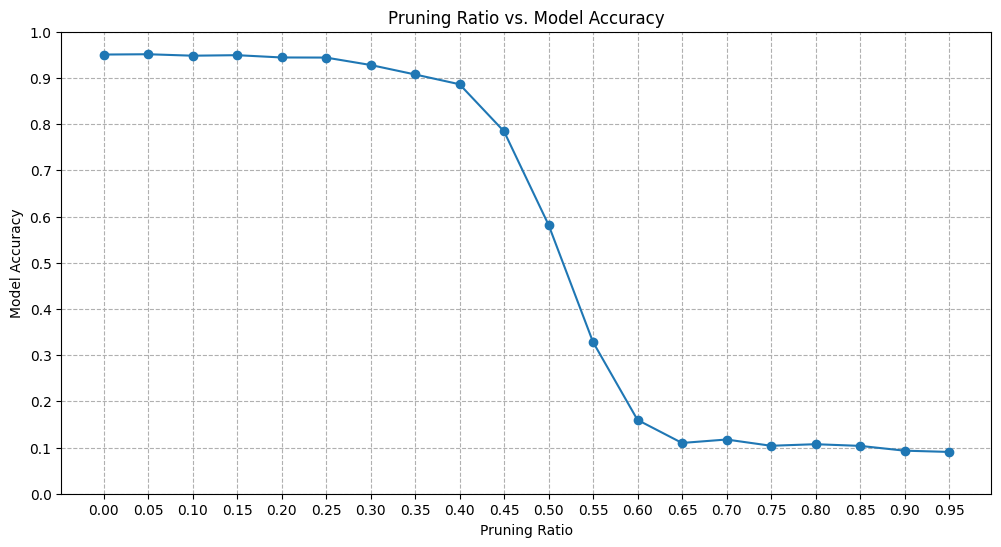

In [12]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(0, 1, 0.05), valid_acc_list, "-o")
plt.grid(ls="--")
plt.xticks(np.arange(0, 1, 0.05))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Pruning Ratio vs. Model Accuracy")
plt.xlabel("Pruning Ratio")
plt.ylabel("Model Accuracy")
plt.show()